# Cartesian Grid defined as an unstructured grid


    -Authors: Niccolò Tubini and Riccardo Rigon
    -License: Creative Commons 4.0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

#################
# Plot settings #
#################

labelSize = 24
titleSize = 22
legendSize = 20
axisTicksSize = 20

lineWidth = 0.6
lineStyle ='-'

markerSize = 5
markerType = 'o'

# FIGURE SIZE
#AxesWidth  = 46; #cm
#AxesHeight = 30; #cm
#plt.rc('figure', figsize=(AxesWidth/2.54,AxesHeight/2.54))

# AXES
plt.rc('axes', edgecolor='black',axisbelow=True, grid=True)

# GRID
plt.rc('grid', color='lightgray', linestyle='solid')

# TICKS
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes',labelsize=22)
plt.rc('legend',fontsize=22)

# FONTS
#font = {'family' : 'sans-serif','weight' : 'normal','size'   : 25}
#plt.rc('font', **font)
#plt.rc('text', usetex=True)
#rc('text.latex', preamble=r'\usepackage{cmbright}')

## Rectangular domain

- **xL**: x coordinate of the left border;
- **xR**: x coordinate of the right border;
- **h**: z coordinate of the bottom defined with respect to a datum, see figure below
- **s**: z coordinate of the bottom defined with respect to a datum, see figure below
- **IMAX**: number of cells in the x-direction
- **KMAX**: number of cells in the z-direction

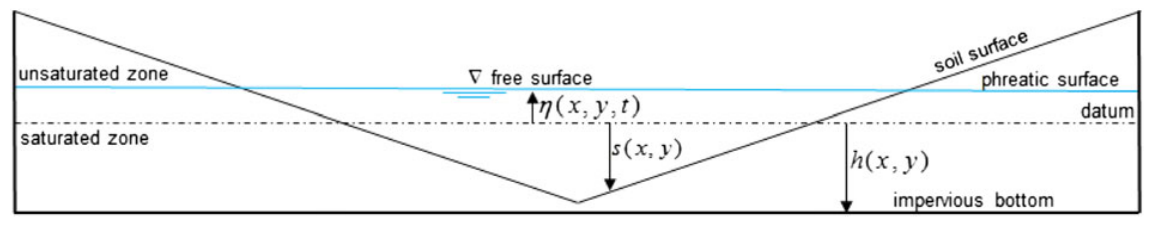

In [2]:
from IPython.display import Image
Image(filename='picture/domain.png',width=800, height=400)

Text(0, 0.5, 'z coordinates')

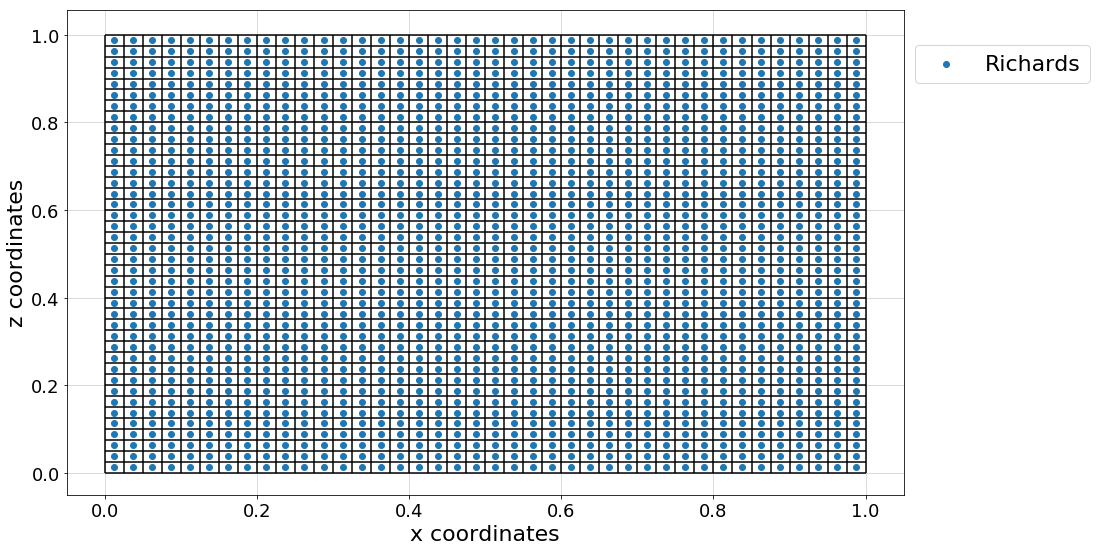

In [3]:
xL = 0
xR = +1

h = 0 
s = -1 

IMAX = 40 
KMAX = 40


#####################################
#####################################

dx = (xR-xL)/IMAX
xc = np.zeros(IMAX)
xDual = np.zeros(IMAX+1)

for i in range(0,IMAX+1,1):
    if (i==IMAX):
        xDual[i] = xL + dx*i
    else:
        xc[i] = xL + dx/2 + dx*i
        xDual[i] = xL + dx*i

    
#print('xc: \n', xc, '\n\n')
#print('xDual: \n', xDual, '\n\n')


dz = (h-s)/KMAX
waterLayer = np.ones(IMAX, dtype=int)*(KMAX+1)
zc = np.zeros((KMAX+1,IMAX))
zDual = np.zeros((KMAX+1,IMAX))
for k in range(0,KMAX+1,1):
    if k==KMAX:
        zDual[k,:] = -h + dz*k
        zc[k,:] = -h + dz*k
    else:
        zDual[k,:] = -h + dz*k
        zc[k,:] = -h + dz/2 + dz*k
    

#print('zc: \n', zc, '\n\n')
#print('zDual: \n', zDual, '\n\n')

fig = plt.figure(figsize=(15,15/1.681))
ax = fig.add_subplot(1, 1, 1)
for k in range(0,KMAX+1,1):
    if k==KMAX:
        ax.scatter(xc, zc[k,:], color='')
    else:
        ax.scatter(xc, zc[k,:], color='tab:blue',label='Richards' if 'Richards' \
            not in plt.gca().get_legend_handles_labels()[1] else '')
    plt.hlines(zDual[k,0], xL, xR, colors='k', linestyles='solid')
for i in range(0,IMAX+1,1):
    plt.vlines(xDual[i], -h, -s, colors='k', linestyles='solid')
    
ax.legend(loc='best', bbox_to_anchor=(1,0.95))
plt.xlabel('x coordinates')
plt.ylabel('z coordinates')

In [4]:
nVertices = (IMAX+1)*(KMAX+1) # numeber of vertices
xVertices = np.zeros(nVertices) # x-coordinates of vertices
zVertices = np.zeros(nVertices) # z-coordinates of vertices

tmp_n = 0

for k in range (0,KMAX+1):
    for i in range(0,IMAX+1,1):
        xVertices[tmp_n] = xL + dx*i
        zVertices[tmp_n] = -h + dz*k
        tmp_n = tmp_n+1

#print('Numeber of vertices: ', nVertices)
#print('x coordinates of vertices: ', xVertices)
#print('z coordinates of vertices: ', zVertices)

In [5]:
nElements = IMAX*KMAX # number of control volumes
elements = np.zeros((nElements,5),dtype=np.int) # vertices defining each control volume of the grid
elementsCentroid = np.zeros((nElements,2)) # coordinates of the control volumes
tmp_n = 0
for k in range(0,KMAX):
    for i in range(0,IMAX):
        elementsCentroid[tmp_n,0] = xL + dx/2+i*dx
        elementsCentroid[tmp_n,1] = -h + dz/2+k*dz
        elements[tmp_n,0] = i+1 + (IMAX+1)*k
        elements[tmp_n,1] = i+2 + (IMAX+1)*k
        elements[tmp_n,3] = i+1 + (IMAX+1)*(k+1)
        elements[tmp_n,2] = i+2 + (IMAX+1)*(k+1)
        elements[tmp_n,4] = 0 # default value for element label. This label is used to associate soil parameters to each element

        tmp_n = tmp_n+1

**Define different regions**

It is possible to assign a label to each element in order to have different paramenters

`regions_xlim` is a list containing the left and right x-coordinate (a pair) of the subregion

`regions_zlim` is a list containing the lower and upper z-coordinate (a pair) of the subregion

`label` is a vector containg the labels of the subregions


In [6]:
regions_xlim = [ [1,4], [0,5] ]
regions_zlim = [ [2,3], [0,1] ]
label = [1,1]

for r in range(0,len(regions_xlim)):
    for i in range(0,nElements):
        if(elementsCentroid[i,0]>=regions_xlim[r][0] and elementsCentroid[i,0]<=regions_xlim[r][1] and
           elementsCentroid[i,1]>=regions_zlim[r][0] and elementsCentroid[i,1]<=regions_zlim[r][1]):
            elements[i,4] = label[r]


**Define the boundary conditions**

In [7]:
nBorderEdges = IMAX*2 + KMAX*2 # number of edges that are on the boundary of the domain
borderEdges = np.zeros((nBorderEdges,3),dtype=np.int) # boundary edges 
tmp_n = 0
#bottom
for i in range(0,IMAX):
    borderEdges[tmp_n,0] = i+1 
    borderEdges[tmp_n,1] = i+2
    borderEdges[tmp_n,2] = 21
    tmp_n = tmp_n+1
#right
for k in range(0,KMAX):
    borderEdges[tmp_n,0] = IMAX+1 + (IMAX+1)*k 
    borderEdges[tmp_n,1] = IMAX+1 + (IMAX+1)*(k+1)
    borderEdges[tmp_n,2] = 10
    tmp_n = tmp_n+1
#top
for i in range(0,IMAX):
    borderEdges[tmp_n,0] = nVertices-i
    borderEdges[tmp_n,1] = nVertices-(i+1)
    borderEdges[tmp_n,2] = 22
    tmp_n = tmp_n+1
#left
for k in range(0,KMAX):
    borderEdges[tmp_n,0] = nVertices-(IMAX) - (IMAX+1)*k
    borderEdges[tmp_n,1] = nVertices-(IMAX) - (IMAX+1)*(k+1)
    borderEdges[tmp_n,2] = 10
    tmp_n = tmp_n+1

**Define a Neumann boundary condition at the top with flux different from 0**

In [8]:
for i in range(0,nBorderEdges-1):
    if (zVertices[int(borderEdges[i,0]-1)]==-s and zVertices[int(borderEdges[i,1]-1)]==-s):
        if( (xVertices[int(borderEdges[i,0]-1)]+xVertices[int(borderEdges[i,1]-1)])/2>=1 and (xVertices[int(borderEdges[i,0]-1)]+xVertices[int(borderEdges[i,1]-1)])/2<=4 ):
            borderEdges[i,2] = 11

**Plot the grid**

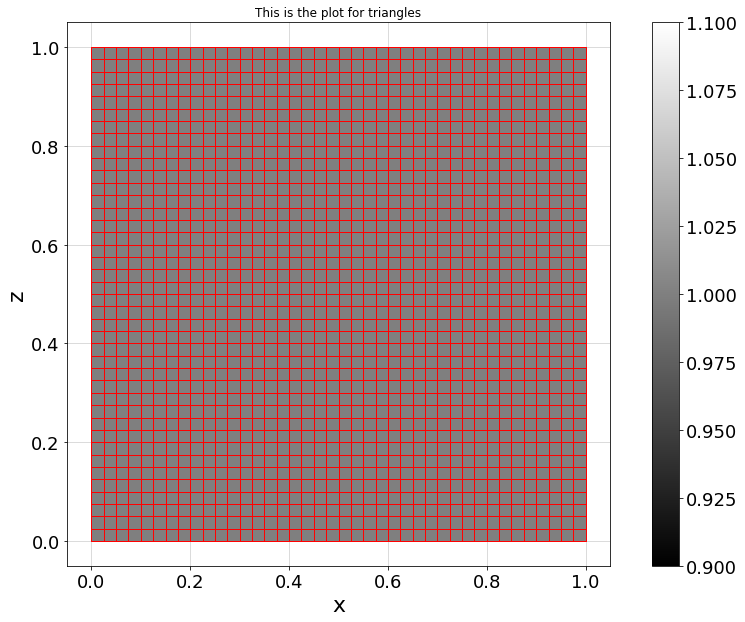

In [9]:
import matplotlib.pyplot as plt
import matplotlib.collections
import numpy as np


def showMeshPlot(nodes, elem, values):

    y = nodes[:,0]
    z = nodes[:,1]

    def quatplot(y,z, quatrangles, values, ax=None, **kwargs):

        if not ax: ax=plt.gca()
        yz = np.c_[y,z]
        verts= yz[quatrangles]
        pc = matplotlib.collections.PolyCollection(verts, **kwargs)
        pc.set_array(values)
        ax.add_collection(pc)
        ax.autoscale()
        return pc

    fig, ax = plt.subplots(figsize=(15,10))
    ax.set_aspect('equal')

    pc = quatplot(y,z, np.asarray(elem), values, ax=ax, 
             edgecolor="red", cmap="gray")
    fig.colorbar(pc, ax=ax)    
    #ax.plot(y,z, marker="o", ls="", color="crimson")

    ax.set(title='This is the plot for triangles', xlabel='x', ylabel='z')

    plt.show()

#nodes = np.array([[0,0], [0,0.5],[0,1],[0.5,0], [0.5,0.5], [0.5,1], [1,0], 
#                  [1,0.5],[1,1]])
#elements = np.array([[0,3,4,1],[1,4,5,2],[3,6,7,4],[4,7,8,5]])
#stresses = np.array([1,2,3,40])
x = np.insert(xVertices,0,-999)
z = np.insert(zVertices,0,-999)
nodes = np.column_stack((x,z))
elem = elements[:,0:4].astype(np.int64)


showMeshPlot(nodes, elem, elements[:,4]) #np.round(psi[50,:],5)

**Save the grid on a .csv file**

In [10]:
with open('C:/Users/Niccolo/OMS/OMS_Project_Richards2D/data/msh/square.csv','w') as file:
    file.write( str(nVertices) + ',' + str(nElements) + ',' + str(nBorderEdges))
    file.write('\n')
    for i in range(0,nVertices):
        file.write( str(xVertices[i]) + ',' + str(zVertices[i]) )
        file.write('\n')
    for i in range(0,nElements):
        file.write( str(int(elements[i,0])) + ',' + str(int(elements[i,1])) + ',' + str(int(elements[i,2])) + ',' + str(int(elements[i,3])) + ',' + str(int(elements[i,4])) )
        file.write('\n')
    for i in range(0, nBorderEdges):
        file.write( str(int(borderEdges[i,0])) + ',' + str(int(borderEdges[i,1])) + ',' + str(int(borderEdges[i,2])) )
        file.write('\n')